In [1]:
# XGBoost Regression Model for Character Bid Prediction
# This notebook builds a regression model using XGBoost to predict the bid prices of characters based on their attributes. We'll use the characters.db SQLite database which contains scraped character auction data.

In [4]:
# Import required libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# Set random seed for reproducibility
np.random.seed(42)

In [5]:
# Connect to the SQLite database
conn = sqlite3.connect('../data/characters_v3.db')

# Read the characters data into a DataFrame
query = "SELECT * FROM characters WHERE status LIKE '%finished%'"
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Print the dataset shape
print(f"Dataset shape: {df.shape}")

# Display the first few rows of the dataset
df.tail()

Dataset shape: (290157, 42)


,id,name,status,bid,level,vocation,server,is_name_contains_special_character,axe_fighting,club_fighting,distance_fighting,fishing,fist_fighting,magic_level,shielding,sword_fighting,mounts,outfits,gold,achievement_points,is_transfer_available,available_charm_points,spent_charm_points,charm_expansion,hunting_task_points,permanent_prey_task_slot,permanent_hunt_task_slot,prey_wildcards,hirelings,hirelings_jobs,hirelings_outfits,auction_start_date_iso,auction_end_date_iso,imbuements,charms,imbuements_list,charms_list,quest_lines,mounts_list,store_mounts_list,outfits_list,store_outfits_list
290152,969992,Ultrabuilder,finished,116,152,paladin,Bombra,0,13,22,89,10,12,21,75,14,0,11,74572,34,1,445,0,0,117,0,0,12,0,0,0,2022-08-28T10:06:00,2022-08-29T10:00:00,0,0,[],[],"[""Dawnport"", ""The Desert Dungeon""]",[],[],"[""Citizen (base)"", ""Hunter (base)"", ""Mage (bas...",[]
290153,969993,Kapozz,finished,5150,483,knight,Honbra,0,22,11,24,10,22,11,104,111,14,20,4605,218,0,200,2200,0,0,0,1,50,1,1,0,2022-08-28T10:06:00,2022-08-29T10:00:00,6,3,"[""Powerful Dragon Hide"", ""Powerful Lich Shroud...","[{""cost"": ""600"", ""name"": ""Dodge""}, {""cost"": ""1...","[""Blood Brothers"", ""Children of the Revolution...","[""Racing Bird"", ""Donkey"", ""War Horse"", ""Kingly...",[],"[""Citizen (base & addon 1)"", ""Hunter (base & a...",[]
290154,969994,Atiradora Vesga,finished,2002,334,paladin,Descubra,0,13,13,109,11,24,30,96,30,8,22,10,271,1,97,2300,0,1308,0,0,48,0,0,0,2022-08-28T10:06:00,2022-09-01T10:00:00,19,3,"[""Powerful Bash"", ""Powerful Chop"", ""Powerful C...","[{""cost"": ""900"", ""name"": ""Curse""}, {""cost"": ""6...","[""Children of the Revolution"", ""Dawnport"", ""Fe...","[""Racing Bird"", ""War Bear"", ""War Horse"", ""Tame...",[],"[""Citizen (base)"", ""Hunter (base & addon 1 & a...",[]
290155,969995,Dandan Bate fofo,finished,2051,277,paladin,Collabra,0,29,13,114,59,28,28,101,13,14,22,1437,260,1,524,2600,0,7242,0,1,24,0,0,0,2022-08-28T10:05:00,2022-08-29T17:00:00,20,2,"[""Powerful Bash"", ""Powerful Blockade"", ""Powerf...","[{""cost"": ""600"", ""name"": ""Dodge""}, {""cost"": ""2...","[""An Uneasy Alliance"", ""Blood Brothers"", ""Chil...","[""Racing Bird"", ""War Bear"", ""Draptor"", ""Stampo...",[],"[""Citizen (base)"", ""Hunter (base & addon 1 & a...","[""Ghost Blade (base & addon 1 & addon 2)""]"
290156,969999,Marcus Kyoo,finished,10500,502,paladin,Honbra,0,13,15,122,16,18,34,95,15,18,22,226,257,0,978,4300,0,2169,0,1,12,1,2,0,2022-08-28T10:06:00,2022-08-29T10:00:00,19,5,"[""Powerful Bash"", ""Powerful Chop"", ""Powerful C...","[{""cost"": ""1,500"", ""name"": ""Divine Wrath""}, {""...","[""Children of the Revolution"", ""Heart of Destr...","[""Racing Bird"", ""War Bear"", ""Draptor"", ""Donkey...","[""Shadow Claw""]","[""Citizen (base)"", ""Hunter (base & addon 2)"", ...","[""Arbalester (base & addon 1 & addon 2)""]"


In [6]:

# Insert servers.json data into the DataFrame
servers_df = pd.read_json('../data/servers.json')
# Merge the servers data with the characters data

# Process servers.json data into a more usable dataframe format
server_data_list = []

# Convert the wide JSON format to a long format
for column in servers_df.columns:
    server_info = servers_df[column]
    
    # Extract data from each server
    server_data = {
        'server_name': server_info['serverName'],
        'server_location': server_info['serverLocation']['string'],
        'pvp_type': server_info['pvpType']['string'],
        'battleye': server_info['battleye'],
        'experimental': server_info['experimental']
    }
    server_data_list.append(server_data)

# Create a new dataframe with server details
servers_df_processed = pd.DataFrame(server_data_list)

# Rename server_name column to match the 'server' column in the characters dataframe
servers_df_processed = servers_df_processed.rename(columns={'server_name': 'server', 'experimental': 'server_experimental'})


servers_df_processed.head()

# Merge the servers data with the characters data
df = df.merge(servers_df_processed, on='server', suffixes=('', '_drop'))
df = df[[col for col in df.columns if not col.endswith('_drop')]]



In [7]:
# Feature Engineering: Transform list columns into boolean features
import json

# List columns to process
list_columns = [
                'imbuements_list',
                 'charms_list', 
                 'quest_lines', 
                 'mounts_list', 
                'store_mounts_list', 
                # 'outfits_list',
                  'store_outfits_list'
                  ]

print("Processing list columns into boolean features...")

# Function to safely parse JSON strings
def safe_json_parse(json_str):
    try:
        if pd.isna(json_str) or json_str == '' or json_str == '[]':
            return []
        # Handle the case where the string might already be a list
        if isinstance(json_str, list):
            return json_str
        return json.loads(json_str)
    except (json.JSONDecodeError, TypeError):
        return []

# Function to extract hashable items from a list (handling dicts, strings, etc.)
def extract_hashable_items(items_list):
    hashable_items = []
    if isinstance(items_list, list):
        for item in items_list:
            if isinstance(item, dict):
                # For dictionaries, we'll use a key or convert to string
                if 'name' in item:
                    hashable_items.append(item['name'])
                else:
                    hashable_items.append(str(item))
            elif isinstance(item, (str, int, float)):
                hashable_items.append(str(item))
            else:
                hashable_items.append(str(item))
    return hashable_items

# Process each list column
for col in list_columns:
    print(f"\nProcessing {col}:")
    
    # Parse JSON strings in the column
    df[f'{col}_parsed'] = df[col].apply(safe_json_parse)
    
    # Get all unique items across all lists in this column
    all_items = set()
    for items_list in df[f'{col}_parsed']:
        hashable_items = extract_hashable_items(items_list)
        all_items.update(hashable_items)
    
    print(f"Found {len(all_items)} unique items")
    
    # Create boolean features for each unique item
    feature_prefix = col.replace('_list', '').replace('_', '_')
    
    # Limit to most common items to avoid too many features (top 50 per category)
    # if len(all_items) > 50:
    #     # Count frequency of each item
    #     item_counts = {}
    #     for items_list in df[f'{col}_parsed']:
    #         hashable_items = extract_hashable_items(items_list)
    #         for item in hashable_items:
    #             item_counts[item] = item_counts.get(item, 0) + 1
        
    #     # Take top 50 most frequent items
    #     sorted_items = sorted(item_counts.items(), key=lambda x: x[1], reverse=True)[:50]
    #     all_items = [item[0] for item in sorted_items]
    #     print(f"Limited to top 50 most frequent items")
    # else:
    all_items = sorted(all_items)
    
    created_features = 0
    for item in all_items:
        if item and len(str(item).strip()) > 0:  # Skip empty strings
            # Clean the item name to create a valid feature name
            feature_name = f"{feature_prefix}_{item}"
            # Replace problematic characters with underscores
            feature_name = feature_name.replace(' ', '_').replace('&', 'and').replace('(', '').replace(')', '').replace('-', '_').replace("'", '').replace('"', '').replace(',', '').replace('.', '').replace(':', '').replace(';', '').replace('/', '_')
            # Remove multiple underscores
            while '__' in feature_name:
                feature_name = feature_name.replace('__', '_')
            # Remove trailing underscores
            feature_name = feature_name.strip('_')
            
            # Ensure feature name is not too long
            if len(feature_name) > 100:
                feature_name = feature_name[:100]
            
            try:
                # Create boolean feature
                df[feature_name] = df[f'{col}_parsed'].apply(
                    lambda x: str(item) in [str(i) for i in extract_hashable_items(x)]
                )
                created_features += 1
            except Exception as e:
                print(f"Error creating feature {feature_name}: {e}")
                continue
    
    # Drop the temporary parsed column
    df.drop(f'{col}_parsed', axis=1, inplace=True)
    
    print(f"Created {created_features} boolean features for {col}")

print(f"\nDataset shape after feature engineering: {df.shape}")
print(f"Added approximately {df.shape[1] - 46} new boolean features")  # 46 was the original column count

Processing list columns into boolean features...

Processing imbuements_list:
Found 23 unique items
Created 23 boolean features for imbuements_list

Processing charms_list:
Found 19 unique items
Created 19 boolean features for charms_list

Processing quest_lines:
Found 43 unique items
Created 43 boolean features for quest_lines

Processing mounts_list:
Found 66 unique items


/tmp/ipykernel_267041/3238119036.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df[f'{col}_parsed'].apply(
/tmp/ipykernel_267041/3238119036.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df[f'{col}_parsed'].apply(
/tmp/ipykernel_267041/3238119036.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

Created 66 boolean features for mounts_list

Processing store_mounts_list:


/tmp/ipykernel_267041/3238119036.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_parsed'] = df[col].apply(safe_json_parse)
/tmp/ipykernel_267041/3238119036.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df[f'{col}_parsed'].apply(


Found 132 unique items


/tmp/ipykernel_267041/3238119036.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df[f'{col}_parsed'].apply(
/tmp/ipykernel_267041/3238119036.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df[f'{col}_parsed'].apply(
/tmp/ipykernel_267041/3238119036.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

Created 132 boolean features for store_mounts_list

Processing store_outfits_list:


/tmp/ipykernel_267041/3238119036.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_parsed'] = df[col].apply(safe_json_parse)
/tmp/ipykernel_267041/3238119036.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df[f'{col}_parsed'].apply(


Found 95 unique items


/tmp/ipykernel_267041/3238119036.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df[f'{col}_parsed'].apply(
/tmp/ipykernel_267041/3238119036.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[feature_name] = df[f'{col}_parsed'].apply(
/tmp/ipykernel_267041/3238119036.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

Created 95 boolean features for store_outfits_list

Dataset shape after feature engineering: (290157, 424)
Added approximately 378 new boolean features


In [8]:
# Show sample of new boolean features created
print("Sample of new boolean features:")

# Find all the new boolean feature columns
original_cols = ['id', 'name', 'status', 'bid', 'level', 'vocation', 'server', 'is_name_contains_special_character',
                'axe_fighting', 'club_fighting', 'distance_fighting', 'fishing', 'fist_fighting', 'magic_level',
                'shielding', 'sword_fighting', 'mounts', 'outfits', 'gold', 'achievement_points', 'is_transfer_available',
                'available_charm_points', 'spent_charm_points', 'charm_expansion', 'hunting_task_points',
                'permanent_prey_task_slot', 'permanent_hunt_task_slot', 'prey_wildcards', 'hirelings', 'hirelings_jobs',
                'hirelings_outfits', 'auction_start_date_iso', 'auction_end_date_iso', 'imbuements', 'charms',
                'imbuements_list', 'charms_list', 'quest_lines', 'mounts_list', 'store_mounts_list', 'outfits_list',
                'store_outfits_list', 'server_location', 'pvp_type', 'battleye', 'server_experimental']

new_features = [col for col in df.columns if col not in original_cols]

print(f"\nTotal new features created: {len(new_features)}")

# Show examples by category
categories = ['imbuements', 'charms', 'quest', 'mounts', 'store_mounts', 'outfits', 'store_outfits']
for category in categories:
    category_features = [f for f in new_features if f.startswith(category)]
    if category_features:
        print(f"\n{category.title()} features ({len(category_features)}):")
        for feature in category_features[:5]:  # Show first 5
            print(f"  - {feature}: {df[feature].sum()} characters have this")
        if len(category_features) > 5:
            print(f"  ... and {len(category_features) - 5} more")

# Show some statistics about the new features
print(f"\nFeature statistics:")
print(f"Total boolean features: {len(new_features)}")
print(f"Features with > 100 positive cases: {sum(1 for f in new_features if df[f].sum() > 100)}")
print(f"Features with > 1000 positive cases: {sum(1 for f in new_features if df[f].sum() > 1000)}")

Sample of new boolean features:

Total new features created: 378

Imbuements features (23):
  - imbuements_Powerful_Bash: 48171 characters have this
  - imbuements_Powerful_Blockade: 30876 characters have this
  - imbuements_Powerful_Chop: 48171 characters have this
  - imbuements_Powerful_Cloud_Fabric: 64905 characters have this
  - imbuements_Powerful_Demon_Presence: 35172 characters have this
  ... and 18 more

Charms features (19):
  - charms_Adrenaline_Burst: 5149 characters have this
  - charms_Bless: 60 characters have this
  - charms_Cleanse: 802 characters have this
  - charms_Cripple: 2004 characters have this
  - charms_Curse: 13668 characters have this
  ... and 14 more

Quest features (43):
  - quest_lines_A_Fathers_Burden: 23048 characters have this
  - quest_lines_An_Uneasy_Alliance: 64543 characters have this
  - quest_lines_Blood_Brothers: 27741 characters have this
  - quest_lines_Child_of_Destiny: 12206 characters have this
  - quest_lines_Children_of_the_Revolution:

In [9]:
# Clean up: Remove original list columns since we now have boolean features
print("Removing original list columns...")

# Drop the original list columns as they're now represented by boolean features
list_columns_to_drop = ['imbuements_list', 'charms_list', 'quest_lines', 'mounts_list', 
                        'store_mounts_list', 'outfits_list', 'store_outfits_list']

for col in list_columns_to_drop:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)
        print(f"Dropped {col}")

print(f"\nFinal dataset shape: {df.shape}")
print(f"Columns remaining: {len(df.columns)}")

# Show updated column list
print("\nColumn categories:")
original_base_cols = ['id', 'name', 'status', 'bid', 'level', 'vocation', 'server', 'is_name_contains_special_character']
stats_cols = [col for col in df.columns if col.endswith('_fighting') or col in ['fishing', 'fist_fighting', 'magic_level', 'shielding']]
other_numeric = ['mounts', 'outfits', 'gold', 'achievement_points', 'available_charm_points', 'spent_charm_points', 
                'charm_expansion', 'hunting_task_points', 'permanent_prey_task_slot', 'permanent_hunt_task_slot', 
                'prey_wildcards', 'hirelings', 'hirelings_jobs', 'hirelings_outfits', 'imbuements', 'charms']
boolean_cols = ['is_transfer_available', 'battleye', 'server_experimental']
date_cols = ['auction_start_date_iso', 'auction_end_date_iso']
categorical_cols = ['server_location', 'pvp_type']
boolean_features = [col for col in df.columns if col not in (original_base_cols + stats_cols + other_numeric + boolean_cols + date_cols + categorical_cols)]

print(f"Base columns: {len(original_base_cols)}")
print(f"Fighting/skill stats: {len(stats_cols)}")
print(f"Other numeric: {len(other_numeric)}")
print(f"Boolean flags: {len(boolean_cols)}")
print(f"Date columns: {len(date_cols)}")
print(f"Categorical: {len(categorical_cols)}")
print(f"New boolean features: {len(boolean_features)}")

Removing original list columns...
Dropped imbuements_list
Dropped charms_list
Dropped quest_lines
Dropped mounts_list
Dropped store_mounts_list
Dropped outfits_list
Dropped store_outfits_list

Final dataset shape: (290157, 417)
Columns remaining: 417

Column categories:
Base columns: 8
Fighting/skill stats: 8
Other numeric: 16
Boolean flags: 3
Date columns: 2
Categorical: 2
New boolean features: 378


In [8]:
import os

# Check data types and prepare for the ML pipeline
print("Data types summary:")
print(df.dtypes.value_counts())

# Show first few rows with some of the new features
print("\nSample of data with new boolean features:")
sample_cols = ['name', 'level', 'vocation', 'bid'] + [col for col in df.columns if col.startswith('imbuements_')][:3] + [col for col in df.columns if col.startswith('quest_')][:3]
if len(sample_cols) > 4:
    print(df[sample_cols].head())

print(f"\nDataset ready for ML pipeline with {df.shape[0]} rows and {df.shape[1]} features.")

# Check for behavioral patterns in the numeric data
print("Summary statistics for numerical columns:")
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(df[numeric_cols].describe())

# Look for missing values and correlations with bid price
print("\nTop 10 correlated features with bid price:")
correlations = df[numeric_cols].corr()['bid'].sort_values(ascending=False)
print(correlations.head(10))

# Export the dataframe to CSV for backup or external analysis
# Create directory if it doesn't exist
# Export to CSV
export_path = '../data/characters_processed.csv'
df.to_csv(export_path, index=False)
print(f"\nDataset exported to {export_path}")

Data types summary:
bool      380
int64      29
object      8
Name: count, dtype: int64

Sample of data with new boolean features:
                name  level  vocation  bid  imbuements_Powerful_Bash  \
0           Areczekk     37   paladin  201                     False   
1             Aj Dzi    110  sorcerer  521                     False   
2          Obahowsky      8  sorcerer  102                     False   
3  Lucky Elder Druid     24     druid   80                     False   
4      Nevermain Tim     30     druid   75                     False   

   imbuements_Powerful_Blockade  imbuements_Powerful_Chop  \
0                         False                     False   
1                         False                     False   
2                         False                     False   
3                         False                     False   
4                         False                     False   

   quest_lines_A_Fathers_Burden  quest_lines_An_Uneasy_Alliance  \
0 

In [10]:
# Check for missing values
print("Missing values per column:")
print(df.isna().sum())

# Get basic statistics of numerical features
print("\nBasic statistics:")
df.describe()

Missing values per column:
id                                                          0
name                                                        0
status                                                      0
bid                                                         0
level                                                       0
                                                           ..
store_outfits_Trailblazer_base_and_addon_1_and_addon_2      0
store_outfits_Trophy_Hunter_base_and_addon_1_and_addon_2    0
store_outfits_Trophy_Hunter_base                            0
store_outfits_Winter_Warden_base_and_addon_1_and_addon_2    0
store_outfits_Winter_Warden_base                            0
Length: 417, dtype: int64

Basic statistics:


,id,bid,level,is_name_contains_special_character,axe_fighting,club_fighting,distance_fighting,fishing,fist_fighting,magic_level,shielding,sword_fighting,mounts,outfits,gold,achievement_points,is_transfer_available,available_charm_points,spent_charm_points,charm_expansion,hunting_task_points,permanent_prey_task_slot,permanent_hunt_task_slot,prey_wildcards,hirelings,hirelings_jobs,hirelings_outfits,imbuements,charms
count,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,2.901570e+05,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000,290157.000000
mean,589528.366998,2231.896963,214.681958,0.002926,23.867175,21.857525,39.900740,14.040071,13.084330,45.111350,66.071744,31.107673,4.830874,16.246181,1.436163e+05,28.587647,0.961810,225.666167,820.099808,0.034185,550.866876,0.003167,0.083027,24.294351,0.018828,0.024301,0.001796,4.229376,1.066754
std,285662.713463,6781.847421,179.373405,0.054013,26.586103,22.472713,41.035106,9.528567,4.864632,33.680054,33.329082,32.213940,7.106795,6.567118,1.028562e+06,91.560000,0.191654,279.447768,1615.285796,0.181704,2391.567572,0.056189,0.276062,19.230584,0.159419,0.228258,0.050435,7.656249,1.961691
min,5.000000,57.000000,8.000000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,10.000000,10.000000,0.000000,11.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,351770.000000,200.000000,86.000000,0.000000,12.000000,12.000000,12.000000,10.000000,10.000000,11.000000,33.000000,13.000000,1.000000,11.000000,2.220000e+03,0.000000,1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,646575.000000,504.000000,156.000000,0.000000,13.000000,13.000000,18.000000,10.000000,11.000000,32.000000,75.000000,15.000000,2.000000,14.000000,2.451100e+04,0.000000,1.000000,125.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,851820.000000,1801.000000,299.000000,0.000000,16.000000,17.000000,88.000000,10.000000,14.000000,75.000000,99.000000,30.000000,6.000000,19.000000,1.209930e+05,0.000000,1.000000,347.000000,800.000000,0.000000,166.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,6.000000,1.000000
max,969999.000000,412000.000000,1725.000000,1.000000,138.000000,134.000000,140.000000,102.000000,114.000000,142.000000,128.000000,135.000000,74.000000,75.000000,2.218349e+08,1203.000000,1.000000,8345.000000,17400.000000,1.000000,191279.000000,1.000000,2.000000,53.000000,10.000000,4.000000,6.000000,24.000000,19.000000


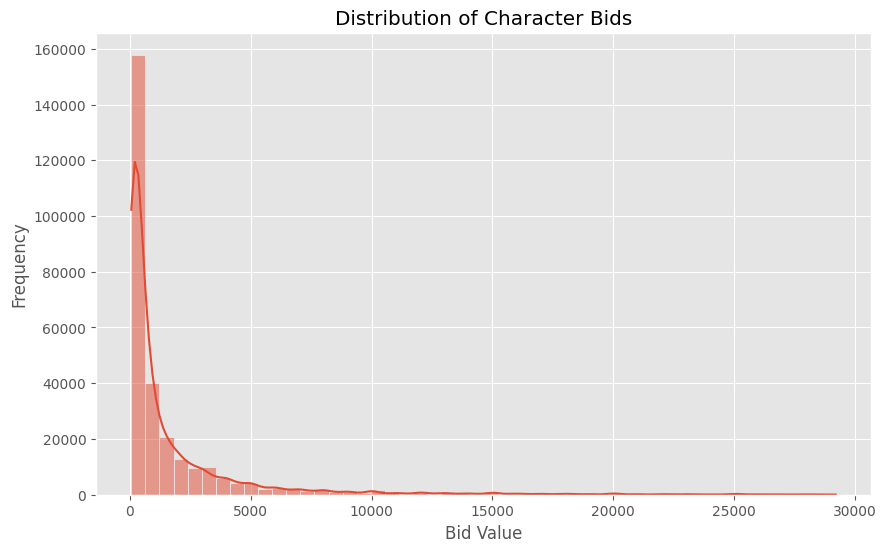

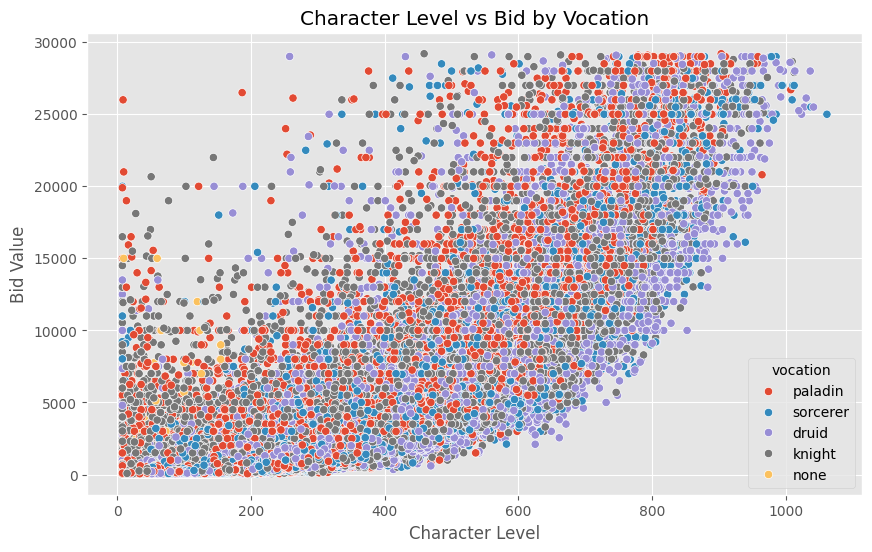

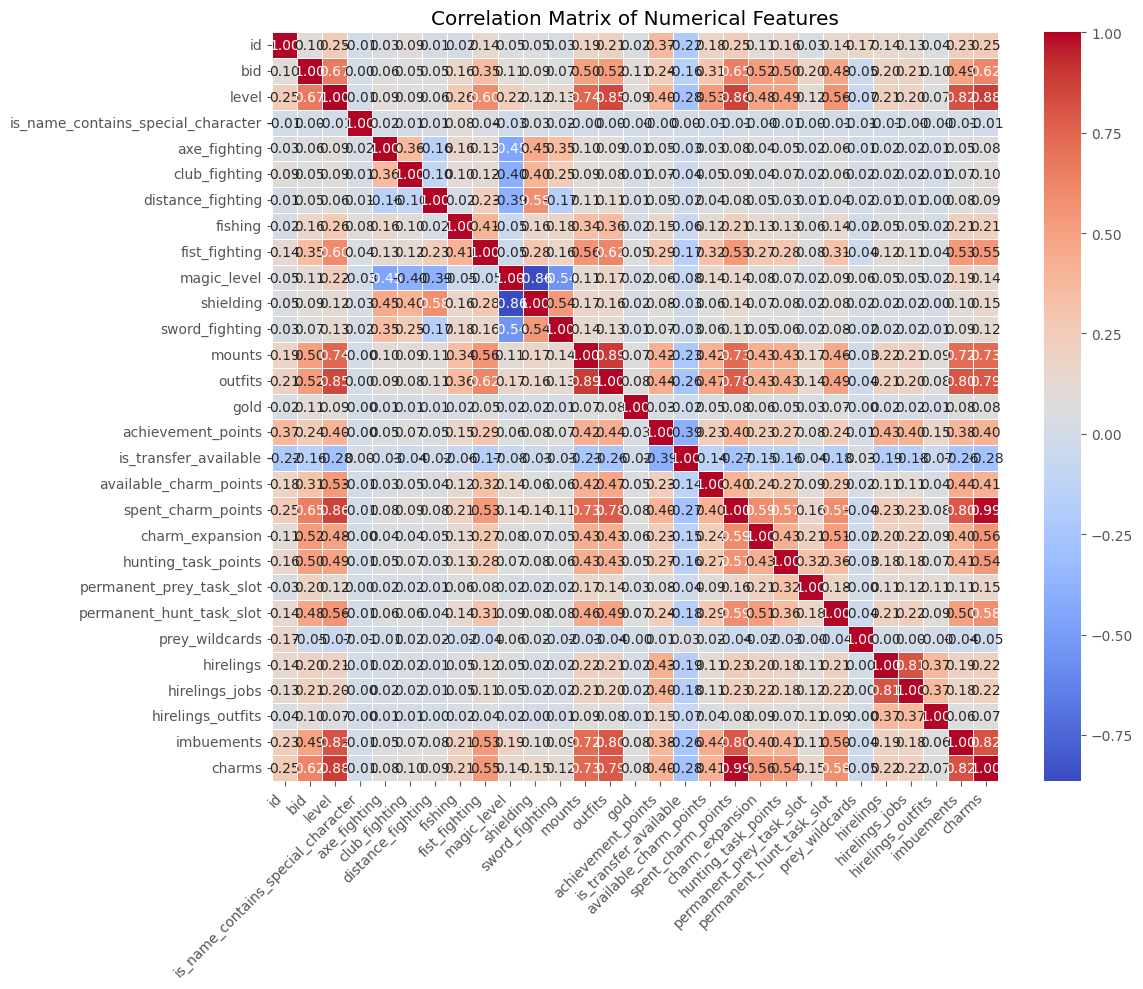

In [11]:
# Visualize the distribution of bids
plt.figure(figsize=(10, 6))
# Calculate the 99th percentile to exclude extreme outliers
bid_99_percentile = np.percentile(df['bid'], 99)
# Plot histogram with values up to 99th percentile
sns.histplot(df[df['bid'] <= bid_99_percentile]['bid'], kde=True, bins=50)
plt.title('Distribution of Character Bids')
plt.xlabel('Bid Value')
plt.ylabel('Frequency')
plt.show()

# Visualize the relationship between level and bid
plt.figure(figsize=(10, 6))
# Filter out extreme bid values for the scatter plot as well
df_filtered = df[df['bid'] <= bid_99_percentile]
sns.scatterplot(x='level', y='bid', hue='vocation', data=df_filtered)
plt.title('Character Level vs Bid by Vocation')
plt.xlabel('Character Level')
plt.ylabel('Bid Value')
plt.show()

# Create correlation matrix for numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numerical_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
# Feature Engineering and Data Preparatio

# Load the processed dataset
# df = pd.read_csv('../data/characters_processed.csv', na_filter=False)

# print(f"Loaded processed dataset with shape: {df.shape}")
# print(f"Dataset loaded successfully from ../data/characters_processed.csv")

# Fix server location mapping - convert "NA" to "NAM" for consistency
df['server_location'] = df['server_location'].replace('NA', 'NAM')
print(f"Server location mapping updated: {df['server_location'].value_counts()}")

# Convert date columns to datetime objects and extract features if needed
df['auction_start_date'] = pd.to_datetime(df['auction_start_date_iso'])
df['auction_end_date'] = pd.to_datetime(df['auction_end_date_iso'])
df['auction_duration_hours'] = (df['auction_end_date'] - df['auction_start_date']).dt.total_seconds() / 3600
# Add a feature for days since the first auction (account age proxy)
first_auction_date = df['auction_start_date'].min()
df['days_since_first_auction'] = (df['auction_start_date'] - first_auction_date).dt.days

print(f"First auction date: {first_auction_date}")
print(f"Date range: {df['auction_start_date'].min()} to {df['auction_start_date'].max()}")
print(f"Days since first auction range: {df['days_since_first_auction'].min()} to {df['days_since_first_auction'].max()}")

# Add a feature for days since the first auction of that server
server_first_auction = df.groupby('server')['auction_start_date'].min().rename('server_first_auction')
df = df.merge(server_first_auction.to_frame(), left_on='server', right_index=True)
df['days_since_server_first_auction'] = (df['auction_start_date'] - df['server_first_auction']).dt.days

print(f"Days since server first auction range: {df['days_since_server_first_auction'].min()} to {df['days_since_server_first_auction'].max()}")

# Drop the temporary column
df.drop('server_first_auction', axis=1, inplace=True)


# Clean data by removing outliers
# Filter out extreme bid values (>99th percentile)
bid_99_percentile = np.percentile(df['bid'], 99)
df = df[df['bid'] <= bid_99_percentile]


# Create a feature for auction time of day (could affect bidding behavior)
df['auction_hour'] = df['auction_start_date'].dt.hour
df['auction_day_of_week'] = df['auction_start_date'].dt.dayofweek

# Add Volume of Bids last week and last month for that server
# df['bid_volume_last_7_days'] = df['server'].map(df[df['auction_end_date_iso'].astype('datetime64[ns]') >= pd.Timestamp.now() - pd.Timedelta(days=7)].groupby('server')['bid'].sum()).fillna(0)


# Define features and target variable
X = df.drop(['id', 'name', 'status', 'bid', 'auction_start_date_iso', 'auction_end_date_iso', 
              'auction_start_date', 'auction_end_date'], axis=1)
y = df['bid']

# Print remaining feature columns
print(f"Feature columns ({len(X.columns)}):\n{X.columns.tolist()}")
print(f"Target variable: bid")

Server location mapping updated: server_location
BR     128279
NAM     84066
EU      77812
Name: count, dtype: int64
First auction date: 2020-08-26 10:03:00
Date range: 2020-08-26 10:03:00 to 2022-08-28 10:09:00
Days since first auction range: 0 to 732


/tmp/ipykernel_267041/1061532666.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['auction_start_date'] = pd.to_datetime(df['auction_start_date_iso'])
/tmp/ipykernel_267041/1061532666.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['auction_end_date'] = pd.to_datetime(df['auction_end_date_iso'])
/tmp/ipykernel_267041/1061532666.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

Days since server first auction range: 0 to 732
Feature columns (416):
['level', 'vocation', 'server', 'is_name_contains_special_character', 'axe_fighting', 'club_fighting', 'distance_fighting', 'fishing', 'fist_fighting', 'magic_level', 'shielding', 'sword_fighting', 'mounts', 'outfits', 'gold', 'achievement_points', 'is_transfer_available', 'available_charm_points', 'spent_charm_points', 'charm_expansion', 'hunting_task_points', 'permanent_prey_task_slot', 'permanent_hunt_task_slot', 'prey_wildcards', 'hirelings', 'hirelings_jobs', 'hirelings_outfits', 'imbuements', 'charms', 'server_location', 'pvp_type', 'battleye', 'server_experimental', 'imbuements_Powerful_Bash', 'imbuements_Powerful_Blockade', 'imbuements_Powerful_Chop', 'imbuements_Powerful_Cloud_Fabric', 'imbuements_Powerful_Demon_Presence', 'imbuements_Powerful_Dragon_Hide', 'imbuements_Powerful_Electrify', 'imbuements_Powerful_Epiphany', 'imbuements_Powerful_Featherweight', 'imbuements_Powerful_Frost', 'imbuements_Powerful_

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Identify categorical columns for preprocessing
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"\nNumerical columns: {len(numerical_cols)}")

X_train.head()

# Print unique server location values to understand the data
print("Unique server locations:")
print(X['server_location'].value_counts())

print("\nUnique PVP types:")
print(X['pvp_type'].value_counts())

print("\nUnique vocations:")
print(X['vocation'].value_counts())

Training set shape: (201078, 416)
Testing set shape: (86177, 416)

Categorical columns: ['vocation', 'server', 'server_location', 'pvp_type', 'battleye', 'server_experimental', 'imbuements_Powerful_Bash', 'imbuements_Powerful_Blockade', 'imbuements_Powerful_Chop', 'imbuements_Powerful_Cloud_Fabric', 'imbuements_Powerful_Demon_Presence', 'imbuements_Powerful_Dragon_Hide', 'imbuements_Powerful_Electrify', 'imbuements_Powerful_Epiphany', 'imbuements_Powerful_Featherweight', 'imbuements_Powerful_Frost', 'imbuements_Powerful_Lich_Shroud', 'imbuements_Powerful_Precision', 'imbuements_Powerful_Quara_Scale', 'imbuements_Powerful_Reap', 'imbuements_Powerful_Scorch', 'imbuements_Powerful_Slash', 'imbuements_Powerful_Snake_Skin', 'imbuements_Powerful_Strike', 'imbuements_Powerful_Swiftness', 'imbuements_Powerful_Vampirism', 'imbuements_Powerful_Venom', 'imbuements_Powerful_Vibrancy', 'imbuements_Powerful_Void', 'charms_Adrenaline_Burst', 'charms_Bless', 'charms_Cleanse', 'charms_Cripple', 'charms

In [14]:
# Create preprocessing transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Preprocess the training and testing data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
feature_names = (numerical_cols + 
                preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist())

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed testing data shape: {X_test_processed.shape}")

Processed training data shape: (201078, 883)
Processed testing data shape: (86177, 883)


In [21]:
# Initialize and train the XGBoost regressor

# {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.9}

model = xgb.XGBRegressor(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=8,
    min_child_weight=1,
    # gamma=1,
    # alpha=10,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',
    device="cuda",
    # booster='dart',
    # eval_metric='rmse',
    early_stopping_rounds=30,
)

# Train the model
model.fit(X_train_processed, y_train, 
          eval_set=[(X_train_processed, y_train), (X_test_processed, y_test)],
          verbose=False)

# Make predictions
y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)

/home/alvaro/.pyenv/versions/3.13.3/lib/python3.13/site-packages/xgboost/core.py:729: UserWarning: [23:33:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [20]:
import catboost as cb
from catboost import CatBoostRegressor

# Import CatBoost

# Initialize CatBoost regressor
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    l2_leaf_reg=3,
    bootstrap_type='Bernoulli',  # Use Bernoulli bootstrap to enable subsample
    subsample=0.8,
    # colsample_bylevel=0.8,  # Removed: not supported on GPU for regression
    random_seed=42,
    verbose=False,
    task_type="GPU",  # Use GPU if available
    devices='0',      # GPU device
    early_stopping_rounds=50
)

# Train the CatBoost model
catboost_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=categorical_cols,  # Specify categorical features
    verbose=False
)

def evaluate_model(y_true, y_pred, dataset_name):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)          # scale-free
    r2   = r2_score(y_true, y_pred)
    ev   = explained_variance_score(y_true, y_pred)

    # Two handy relative error measures
    nrmse = rmse / (y_true.max() - y_true.min())                   # 0–1 scale
    srmse = rmse / np.std(y_true, ddof=0)                          # vs target σ

    metrics = {
        "MSE":  mse,
        "RMSE": rmse,
        "NRMSE_range": nrmse,
        "SRMSE_std":  srmse,
        "MAE":  mae,
        "MAPE": mape,
        "R2":   r2,
        "Explained_Variance": ev,
    }

    print(f"\n{dataset_name} metrics")
    for k, v in metrics.items():
        print(f"{k:18s}: {v:.4f}" if k != "MSE" else f"{k:18s}: {v:,.2f}")

    return metrics

# Make predictions
y_train_pred_cat = catboost_model.predict(X_train)
y_test_pred_cat = catboost_model.predict(X_test)

# Evaluate the CatBoost model
print("CatBoost Model Performance:")
evaluate_model(y_train, y_train_pred_cat, "CatBoost Training")
evaluate_model(y_test, y_test_pred_cat, "CatBoost Testing")

CatBoost Model Performance:

CatBoost Training metrics
MSE               : 368,947.84
RMSE              : 607.4108
NRMSE_range       : 0.0208
SRMSE_std         : 0.1858
MAE               : 309.3375
MAPE              : 0.4795
R2                : 0.9655
Explained_Variance: 0.9655

CatBoost Testing metrics
MSE               : 747,854.83
RMSE              : 864.7860
NRMSE_range       : 0.0298
SRMSE_std         : 0.2587
MAE               : 368.1127
MAPE              : 0.4954
R2                : 0.9331
Explained_Variance: 0.9331


{'MSE': 747854.8281380916,
 'RMSE': np.float64(864.7860013541452),
 'NRMSE_range': np.float64(0.029774005899609064),
 'SRMSE_std': np.float64(0.2587026888993297),
 'MAE': 368.1127063884197,
 'MAPE': 0.4954026565104807,
 'R2': 0.9330729187562566,
 'Explained_Variance': 0.9330747544608743}

In [43]:
X_kfold = preprocessor.fit_transform(X)


dtrain = xgb.DMatrix(X_kfold, label=y)

params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.1,
    "max_depth": 8,
    "min_child_weight": 5,
    "gamma": 1,
    "alpha": 10,
    "subsample": 0.9,
    "colsample_bytree": 0.7,
    "tree_method": "hist",    # GPU version
    "device": "cuda",         # Use GPU
    "eval_metric": "rmse",
    "seed": 42
}

cv_res = xgb.cv(
    params,
    dtrain,
    num_boost_round=5_000,
    nfold=5,
    early_stopping_rounds=50,
    metrics="rmse",
    as_pandas=True,
    verbose_eval=False
)

print("Best CV RMSE:", cv_res["test-rmse-mean"].min())
# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
train_ev = explained_variance_score(y_train, y_train_pred)
test_ev = explained_variance_score(y_test, y_test_pred)
# Print evaluation metrics
print(f"\nTraining RMSE: {train_rmse:.2f}")
print(f"Training R^2: {train_r2:.4f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training MAPE: {train_mape:.4f}")
print(f"Training Explained Variance: {train_ev:.4f}")

print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Testing R^2: {test_r2:.4f}")
print(f"Testing MAE: {test_mae:.2f}")
print(f"Testing MAPE: {test_mape:.4f}")
print(f"Testing Explained Variance: {test_ev:.4f}")



: 

In [22]:
# Evaluate the model
def evaluate_model(y_true, y_pred, dataset_name):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)          # scale-free
    r2   = r2_score(y_true, y_pred)
    ev   = explained_variance_score(y_true, y_pred)

    # Two handy relative error measures
    nrmse = rmse / (y_true.max() - y_true.min())                   # 0–1 scale
    srmse = rmse / np.std(y_true, ddof=0)                          # vs target σ

    metrics = {
        "MSE":  mse,
        "RMSE": rmse,
        "NRMSE_range": nrmse,
        "SRMSE_std":  srmse,
        "MAE":  mae,
        "MAPE": mape,
        "R2":   r2,
        "Explained_Variance": ev,
    }

    print(f"\n{dataset_name} metrics")
    for k, v in metrics.items():
        print(f"{k:18s}: {v:.4f}" if k != "MSE" else f"{k:18s}: {v:,.2f}")

    return metrics

# Evaluate on training data
evaluate_model(y_train, y_train_pred, "Training")

# Evaluate on testing data
evaluate_model(y_test, y_test_pred, "Testing")


Training metrics
MSE               : 185,709.53
RMSE              : 430.9403
NRMSE_range       : 0.0148
SRMSE_std         : 0.1318
MAE               : 250.7929
MAPE              : 0.4311
R2                : 0.9826
Explained_Variance: 0.9826

Testing metrics
MSE               : 734,935.31
RMSE              : 857.2837
NRMSE_range       : 0.0295
SRMSE_std         : 0.2565
MAE               : 361.0298
MAPE              : 0.4627
R2                : 0.9342
Explained_Variance: 0.9342


{'MSE': 734935.3125,
 'RMSE': np.float64(857.2836826278685),
 'NRMSE_range': np.float64(0.029515706063965176),
 'SRMSE_std': np.float64(0.25645835327822986),
 'MAE': 361.02984619140625,
 'MAPE': 0.46269384026527405,
 'R2': 0.9342291355133057,
 'Explained_Variance': 0.934230185537682}

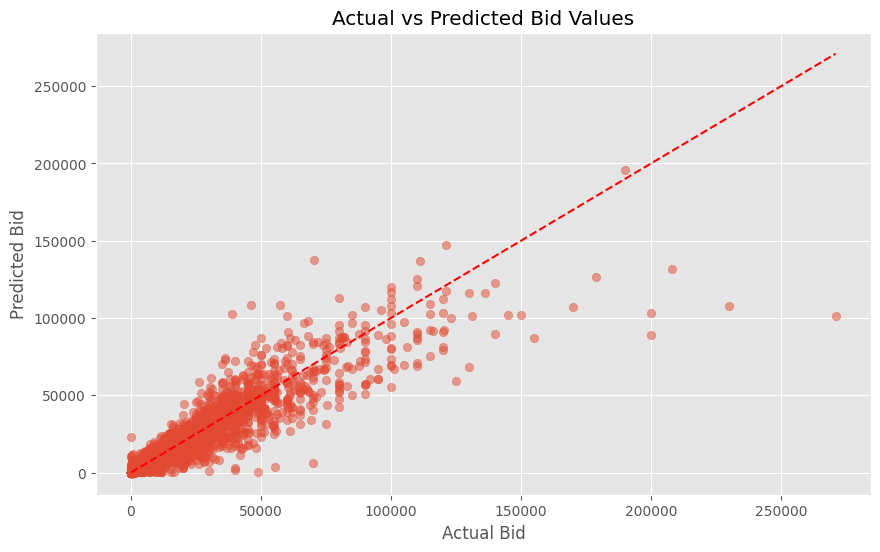

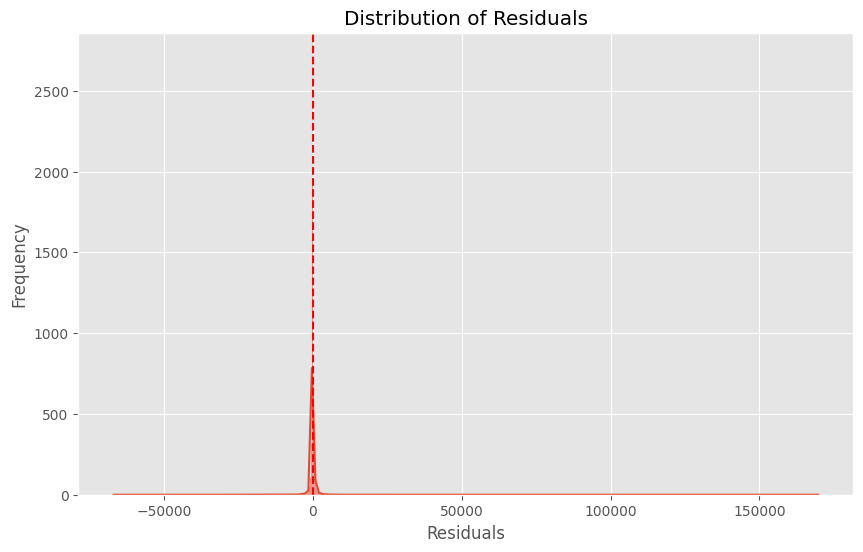

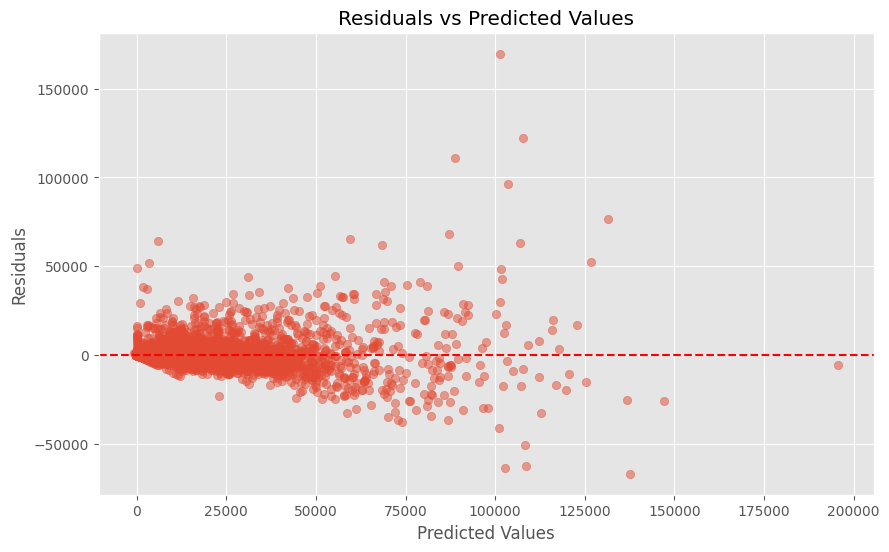

In [16]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Bid')
plt.ylabel('Predicted Bid')
plt.title('Actual vs Predicted Bid Values')
plt.show()

# Visualize residuals
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

# Visualize residuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


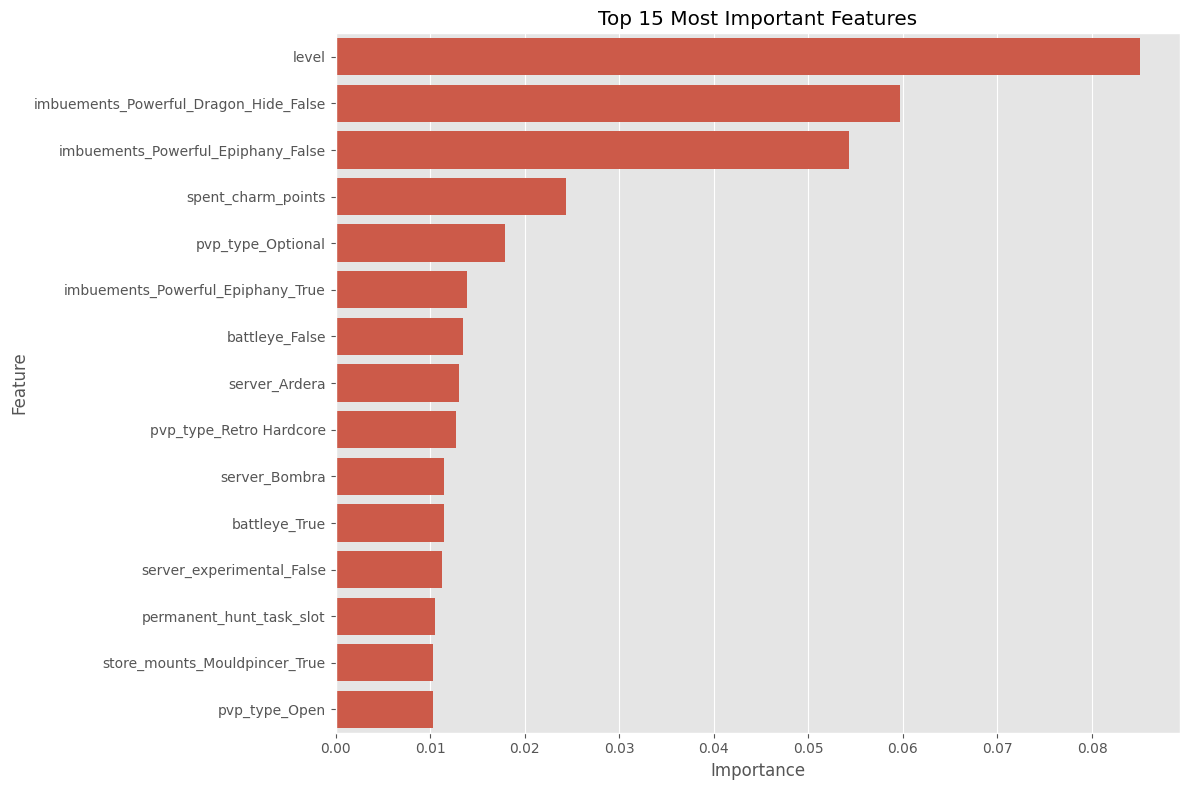

In [31]:
# Get feature importance
importance = model.feature_importances_

# Only use the actual number of features used in the model
feature_importance = pd.DataFrame({
    'Feature': feature_names[:len(importance)],
    'Importance': importance
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
# Optional: Hyperparameter tuning with cross-validation
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [600, 800, 1400, 2000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 8],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Uncomment to run grid search (may take some time)

xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    random_state=42, 
    # device="cuda"
)
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_processed, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

# Train model with best parameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_processed)
evaluate_model(y_test, y_pred_best, "Best Model Testing")


Fitting 5 folds for each of 972 candidates, totalling 4860 fits


In [27]:
# Save the trained model
import pickle

# Save the model
model_filename = '../models/xgboost_character_bid_model_v3.pkl'

# Create directory if it doesn't exist
import os
os.makedirs(os.path.dirname(model_filename), exist_ok=True)

# Save both the model and the preprocessor
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model, 'preprocessor': preprocessor}, f)

print(f"Model saved to {model_filename}")

Model saved to ../models/xgboost_character_bid_model_v3.pkl


In [30]:
# Function to make predictions for new characters
def predict_character_bid(character_data):
    # Convert to DataFrame if not already
    if not isinstance(character_data, pd.DataFrame):
        character_data = pd.DataFrame([character_data])
    
    # Preprocess the data
    X_new = preprocessor.transform(character_data)
    
    # Make predictions
    predictions = model.predict(X_new)
    
    return predictions[0]

id = 1 # Create a sample character to predict its bid
# Replace with actual data based on your database schema
sample_character = X_test.iloc[id].copy()  # Take a random sample from the test set

# Display sample character
print("Sample character features:")
for col, val in sample_character.items():
    print(f"{col}: {val}")

# Predict bid
predicted_bid = predict_character_bid(sample_character.to_frame().T)
print(f"\nPredicted bid: {predicted_bid:.2f}")
print(f"Actual bid: {y_test.iloc[id]:.2f}")

Sample character features:
level: 51
vocation: sorcerer
server: Serdebra
is_name_contains_special_character: 0
axe_fighting: 13
club_fighting: 12
distance_fighting: 12
fishing: 10
fist_fighting: 10
magic_level: 65
shielding: 34
sword_fighting: 14
mounts: 0
outfits: 11
gold: 164554
achievement_points: 2
is_transfer_available: 1
available_charm_points: 30
spent_charm_points: 0
charm_expansion: 0
hunting_task_points: 0
permanent_prey_task_slot: 0
permanent_hunt_task_slot: 0
prey_wildcards: 29
hirelings: 0
hirelings_jobs: 0
hirelings_outfits: 0
imbuements: 0
charms: 0
server_location: BR
pvp_type: Open
battleye: False
server_experimental: False
imbuements_Powerful_Bash: False
imbuements_Powerful_Blockade: False
imbuements_Powerful_Chop: False
imbuements_Powerful_Cloud_Fabric: False
imbuements_Powerful_Demon_Presence: False
imbuements_Powerful_Dragon_Hide: False
imbuements_Powerful_Electrify: False
imbuements_Powerful_Epiphany: False
imbuements_Powerful_Featherweight: False
imbuements_Power

## Conclusion and Summary

In this notebook, we have:

1. Loaded character data from the SQLite database
2. Performed exploratory data analysis to understand the dataset
3. Engineered features for our regression model
4. Built an XGBoost regression model to predict character bids
5. Evaluated the model's performance using various metrics
6. Identified the most important features for bid prediction
7. Saved the model for future use

The model's performance can be further improved by:

- Fine-tuning hyperparameters using cross-validation
- Engineering additional features based on domain knowledge
- Collecting more data or addressing any class imbalance issues
- Trying different regression algorithms and ensemble methods